# 自然言語処理とは
私たちが普段使用している言語は**自然言語**と言い、**自然言語処理**はそれをコンピューターに理解させるための技術分野である。自然言語はコンピューターの理解できるプログラミング言語などと違い、柔軟に意味や形を変える。この差が自然言語処理の難しさを生む。

## 単語の意味
文章を理解させるためにはまず単語の意味を理解させる必要がある。単語の意味を理解させる方法として、以下の3つの手法をここでは紹介する。

1. シソーラスによる手法
1. カウントベースの手法
1. 推論ベースの手法(word2vec)

# シソーラス
シソーラスは基本的には類語辞書であり、同義語や類義語が同じグループに分類されている。また、下図のように、単語同士の上位下位の関連性も定義されていることがある。
<img src='https://assets.st-note.com/production/uploads/images/66671667/picture_pc_77da28808628a98829596b0cc92c44c6.png'>

## WordNet
WordNetは自然言語処理の分野において最も有名なシソーラスであり、様々な自然言語処理アプリケーションで活躍している。

## シソーラスの問題点
シソーラスには、大きく分けて3つの問題点がある。

1. 時代の変化に対応することが困難
    - 時代による単語の増加や意味の変化に対応するには更新し続けるしかない
1. 人の作業コストが高い
    - 人力で単語の関連付けを行う必要がある。
1. 単語の細かいニュアンスを表現できない
    - 似たような単語でも意味が違う単語をくみ取ることができない ex)ヴィンテージとレトロ

# カウントベースの手法
この手法では、研究のために収集された大量のテキストデータ（**コーパス**と呼ばれる）を使用する。

## Pythonによるコーパスの下準備
コーパスを利用できる形に変換する実装が以下である。

In [6]:
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {} #単語からIDへ変換
    id_to_word = {} #IDから単語に変換
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

## 単語の分散表現
コンピューターの世界では、色はRGBを数値化したベクトル表現で表される。単語でも同様にベクトル表現を行うことで定量化し、扱いを容易にすることができる。このような表現を、単語の**分散表現**という。

## 分布仮説
「単語の意味は、周囲の単語によって形成される」という仮説を**分布仮説**といい、現代の分散表現の研究はこの仮説に基づいて行われている。これは、コンテキストによって意味が形成されるということである。周囲の単語をどれだけコンテキストの範囲に含めるかを、ウィンドウサイズという言葉で表す。

## 共起行列
分布仮説に基づいて分散表現を行うとき、単純な方法として、その分散表現の対象となる単語の周囲にどのような単語がどれだけ存在するかをカウントし集計する手法がある。これを「カウントベースの手法」または「統計的手法」という。また、各単語についてそのコンテキストに含まれる単語の頻度をカウントし、テーブルにまとめたものを**共起行列**という。コーパスから共起行列を生成する実装は以下。

In [7]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

## ベクトル間の類似度
単語のベクトル表現の類似度の計測には、**コサイン類似度**がよく用いられる。コサイン類似度は、$x$と$y$の2つのベクトルがあるとき、次の式で定義される。
<br>
$$\displaystyle
\text{similarity}(x,y) = \frac{x \cdot y}{\|x\| \|y\|} = \frac{x_1 y_1 + \cdots + x_n y_n}{\sqrt{x_1^2 + \cdots + x_n^2} \sqrt{y_1^2 + \cdots + y_n^2}}
$$
<br>
これは、ベクトルがどれほど同じ向きを向いているかを表す。この実装は下記。

In [8]:
def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出

    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0除算”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

今までに実装した関数を用いて、"You say goodbye and I say hello."という文の中での"you"と"I"の類似度を求めてみる。

In [9]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]  #「you」の単語ベクトル
c1 = C[word_to_id['i']]  #「i」の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067691154799


コサイン類似度は1～-1の値をとるため、これは比較的高い数値といえる。

## 類似単語のランキング表示
使用しやすいように、ある単語（クエリ）が与えられたとき、その単語に類似した単語を上位から順に返す関数を実装する。

In [10]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''類似単語の検索

    :param query: クエリ（テキスト）
    :param word_to_id: 単語から単語IDへのディクショナリ
    :param id_to_word: 単語IDから単語へのディクショナリ
    :param word_matrix: 単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する
    :param top: 上位何位まで表示するか
    '''
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

この関数を先ほどのコーパスにおいてyouで適用すると以下のようになる。

In [11]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


# カウントベースの手法の改善

## 相互情報量
共起行列では2つの単語が共起した回数を要素として持ったが、単語によって登場頻度は異なるため、頻繁に登場する単語ほど実際には関連性がなくても強い関連を示してしまう。この問題を解決するために、**相互情報量**（PMI）と呼ばれる指標が用いられる。これは、確率変数$x,y$を用いて以下の式で定義される。
$${\displaystyle
\text{PMI}(x,y) = log_2 \frac{P(x,y)}{P(x)P(y)}
}$$
<br>
PMIは、値が高いほど$x$の発生と$y$の発生の関連性が高いことを示す。また、2つの単語が共起する回数が0回のとき、PMIは-∞をとってしまうため、実践上では**正の相互情報量**（PPMI）を使用する。
$${\displaystyle
\text{PPMI}(x,y) = \text{max}(0,\text{PMI}(x,y))
}$$
<br>
共起行列をPPMI行列へ変換する実装は以下である。

In [12]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI（正の相互情報量）の作成

    :param C: 共起行列
    :param verbose: 進行状況を出力するかどうか
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

これを実際に使用してみる。

In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


変換ができた。しかし、このPPMI行列は、語彙数が増えるにしたがって次元数も増えていく。数万レベルまで語彙数が増えると実用的ではなくなってくる。この問題を解決するために行われるのが次元削減だ。

## 次元削減
次元削減は文字通りベクトルの次元を削減する手法である。次元削減にもいくつかの方法があるが、ここでは**特異値分解**（SVD）を用いる。SVDは、任意の行列を3つの行列の積へと分解する。数式では次のように表される。
$$
X = USV^\top
$$
SVDは、任意の行列$X$を、3つの行列$U,S,V$の積に分解する。このとき、$U$と$V$は直交行列であり、$S$は対角行列である。先ほどのコーパスにおけるSVDによる次元削減をPythonで実装したのが下記である。

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -4.441e-16 -1.205e-01  0.000e+00 -9.323e-01
 -1.086e-16]


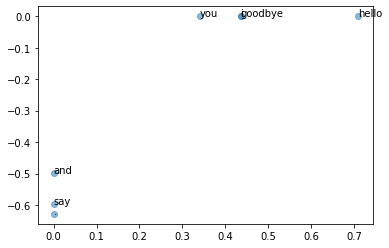

In [15]:
import matplotlib.pyplot as plt

ext = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print(C[0])
print(W[0])
print(U[0])

# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

ここでは小さなコーパスを用いているため結果がわかりにくい。そのため、より大きなコーパスであるPTBデータデットを用いてみる。ここではPTBコーパスの読み込みに、「ゼロから作るDeepLearning②」で提供されているスクリプトを使用する。

In [16]:
import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


扱うのがより大きな行列となるため、より高速なsklearnモジュールのSVDを利用する。

In [17]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...


C:\Users\Kaito\AppData\Local\Temp\ipykernel_19224\3766924727.py:16: RuntimeWarning: overflow encountered in long_scalars
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
C:\Users\Kaito\AppData\Local\Temp\ipykernel_19224\3766924727.py:16: RuntimeWarning: invalid value encountered in log2
  pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)


1.0% done
2.0% done
3.0% done
4.0% done
5.0% done
6.0% done
7.0% done
8.0% done
9.0% done
10.0% done
11.0% done
12.0% done
13.0% done
14.0% done
15.0% done
16.0% done
17.0% done
18.0% done
19.0% done
20.0% done
21.0% done
22.0% done
23.0% done
24.0% done
25.0% done
26.0% done
27.0% done
28.0% done
29.0% done
30.0% done
31.0% done
32.0% done
33.0% done
34.0% done
35.0% done
36.0% done
37.0% done
38.0% done
39.0% done
40.0% done
41.0% done
42.0% done
43.0% done
44.0% done
45.0% done
46.0% done
47.0% done
48.0% done
49.0% done
50.0% done
51.0% done
52.0% done
53.0% done
54.0% done
55.0% done
56.0% done
57.0% done
58.0% done
59.0% done
60.0% done
61.0% done
62.0% done
63.0% done
64.0% done
65.0% done
66.0% done
67.0% done
68.0% done
69.0% done
70.0% done
71.0% done
72.0% done
73.0% done
74.0% done
75.0% done
76.0% done
77.0% done
78.0% done
79.0% done
80.0% done
81.0% done
82.0% done
83.0% done
84.0% done
85.0% done
86.0% done
87.0% done
88.0% done
89.0% done
90.0% done
91.0% done
92.0% do

人間の目で見ても関連性の高いワードが検出されていることが分かる。